In [1]:
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.width', 1000)

# Change the project name here to your project name in your account
client = bigquery.Client(project="dsa3101-434713")

/Users/swislar/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Q1


What are the key factors influencing customer purchasing behavior?

- Analyze historical sales data to identify patterns and trends.
- <strong>Develop customer segmentation models based on purchasing behavior. (Not done)</strong>


### Type of purchases and revenue by month


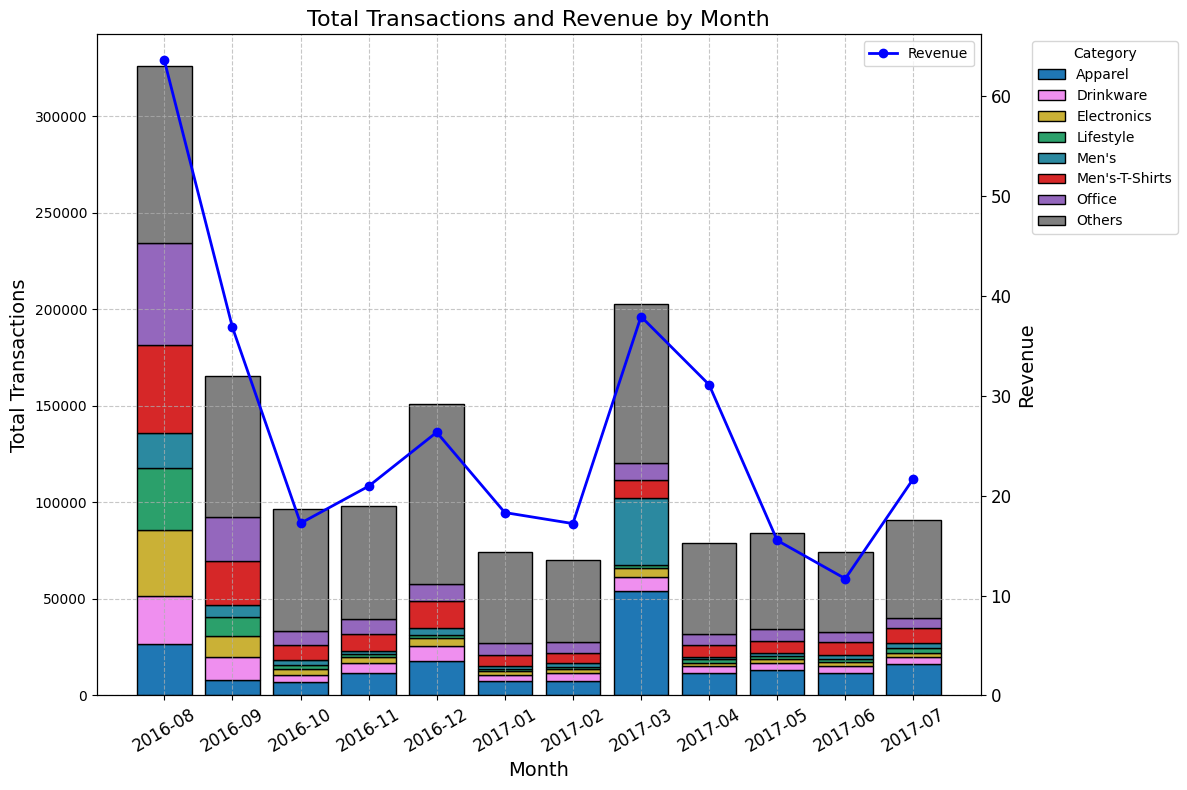

In [2]:
query = """
        SELECT FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS MONTH, product.v2ProductCategory AS Category, SUM(totals.transactions) AS TotalTransactions, SUM(totals.totalTransactionRevenue) AS TotalRevenue
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits, UNNEST(hits.product) AS product
        GROUP BY MONTH, Category
        HAVING TotalTransactions > 0
        ORDER BY MONTH, Category
        """

rows = client.query(query)

result_df = rows.to_dataframe()

# Extract the sub category
result_df['Category'] = result_df['Category'].apply(
    lambda x: x.split("/")[-1] if x.split("/")[-1] != "" else x.split("/")[-2])

# Remove unformatted categories
result_df = result_df.query("Category not in ['(not set)', '${escCatTitle}']")

# Since '2017-08' only contains 1 day of data
result_df = result_df.query("MONTH < '2017-08'")

# Extract the top 5 categories
top_categories = result_df.groupby(
    'Category')['TotalTransactions'].sum().nlargest(7).index

# Create a new column for categories
result_df['Category'] = result_df['Category'].apply(
    lambda x: x if x in top_categories else 'Others'
)

# Pivot the DataFrame to wide format
pivot_df = result_df.pivot_table(
    index='MONTH', columns='Category', values=['TotalTransactions', 'TotalRevenue'], aggfunc='sum', fill_value=0)


# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Initialize the bottom parameter
bottoms = [0] * len(pivot_df)

# Define colors
category_colors = {
    'Apparel': '#1f77b4',  # Blue
    'Drinkware': '#EF8FEF',  # Pink
    'Electronics': '#CAB136',  # Khaki
    'Lifestyle': '#2BA06B',  # Forest green
    "Men's": '#2B89A0',   # Turquoise
    "Men's-T-Shirts": '#d62728',   # Red
    'Office': '#9467bd',   # Purple
    'Others': '#808080'  # Gray for 'Other'
}

# Plot the stacked bar chart on the primary y-axis
for category, color in category_colors.items():
    if category in pivot_df.TotalTransactions.columns:
        ax1.bar(pivot_df.index, pivot_df.TotalTransactions[category], bottom=bottoms,
                label=category, color=color, edgecolor='black')
        bottoms = [bottoms[j] + pivot_df.TotalTransactions[category].iloc[j]
                   for j in range(len(bottoms))]

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(pivot_df.index, pivot_df.TotalRevenue.sum(axis=1)/1e12, marker='o',
         color='b', linestyle='-', linewidth=2, label='Revenue')

# Add labels and titles
ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Total Transactions', fontsize=14)
ax1.set_title('Total Transactions and Revenue by Month', fontsize=16)
ax1.tick_params(axis='x', rotation=30, labelsize=12)
ax1.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_ylabel('Revenue', fontsize=14)
ax2.tick_params(axis='y', labelsize=12)
ax2.legend(loc='upper right')
ax2.set_ylim(bottom=0)

# Add a grid
ax1.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

2016-08: Large number of transactions throughout all Categories

2017-03: There is a large increase in transactions for Men's and Apparel items.


### Visualisation of Customer Recency


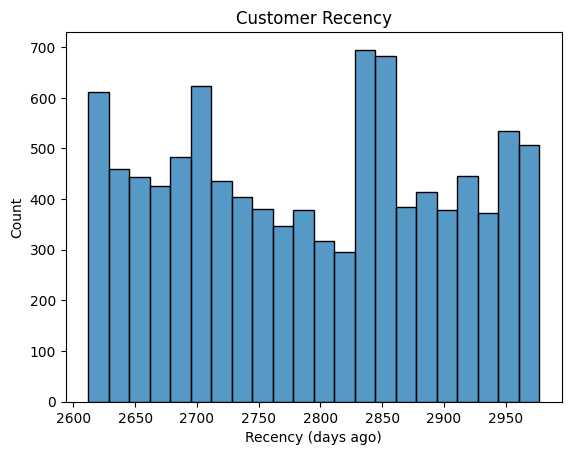

In [3]:
query = f"""
    WITH CustomerRecency AS (
        SELECT
            fullVisitorId AS visitorId,
            CAST(SUBSTRING(date, 1, 4) || '-' || SUBSTRING(date, 5, 2) || '-' || SUBSTRING(date, 7, 2) AS DATE) AS date,
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE totals.transactions >= 1
    )

    -- Number of days between the current date and the date of last purchase
    SELECT
        visitorId,
        DATE_DIFF(CURRENT_DATE(), MAX(date), DAY) AS recency
    FROM
        CustomerRecency
    GROUP BY
        visitorId
    """
rows = client.query(query)

result_df = rows.to_dataframe()

sns.histplot(result_df.recency)

plt.title('Customer Recency')
plt.xlabel('Recency (days ago)')
plt.ylabel('Count')

plt.show()

### Visualisation of Customer Frequency


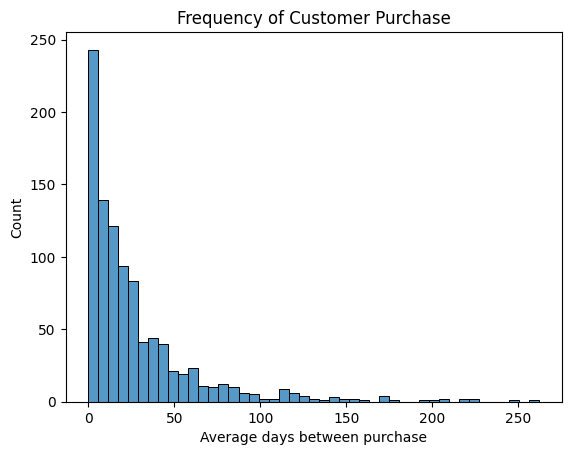

In [4]:
query = f"""
    WITH CustomerFrequency AS (
        SELECT
            fullVisitorId AS visitorId,
            CAST(SUBSTRING(date, 1, 4) || '-' || SUBSTRING(date, 5, 2) || '-' || SUBSTRING(date, 7, 2) AS DATE) AS date,
            COALESCE(totals.transactions, 0) AS transactions,
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE totals.transactions > 0
    ),
    -- Get the date the current purchase and the date of the previous purchase for each customer
    LaggedCustomerFrequency AS (
        SELECT
            LAG(date, 1)
            OVER (PARTITION BY
                    visitorId
                ORDER BY
                    date
                )
            AS previousDate,
            visitorId,
            date
        FROM
            CustomerFrequency
    ),
    -- Number of days between each transaction for each customer
    frequencyData AS (
        SELECT
            visitorId,
            DATE_DIFF(LaggedCustomerFrequency.date, LaggedCustomerFrequency.previousDate, DAY) AS diffDays
        FROM
            LaggedCustomerFrequency
        WHERE
            LaggedCustomerFrequency.previousDate IS NOT NULL
    )

    SELECT
        visitorId,
        AVG(diffDays) AS frequency
    FROM
        frequencyData
    GROUP BY
        visitorId
    """
rows = client.query(query)

result_df = rows.to_dataframe()

sns.histplot(result_df.frequency)

plt.title('Frequency of Customer Purchase')
plt.xlabel('Average days between purchase')
plt.ylabel('Count')

plt.show()

In [5]:
# Double check the count of visitorId is to be the same as ^
query = f"""
    SELECT
        fullVisitorId AS visitorId,
        COUNT(totals.transactions)
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    GROUP BY visitorId
    HAVING COUNT(totals.transactions) > 1
    """
rows = client.query(query)

result_df = rows.to_dataframe()

result_df

,visitorId,f0_
0,3658091589289896549,2
1,9952616174324085427,3
2,7737049103084491745,2
3,4587300217226571258,2
4,6592883580168014282,3
...,...,...
966,3862093055992617004,2
967,9044444019630799818,2
968,7937009225076356808,2
969,4698134628151668241,2


### Visualisation of Customer Monetary


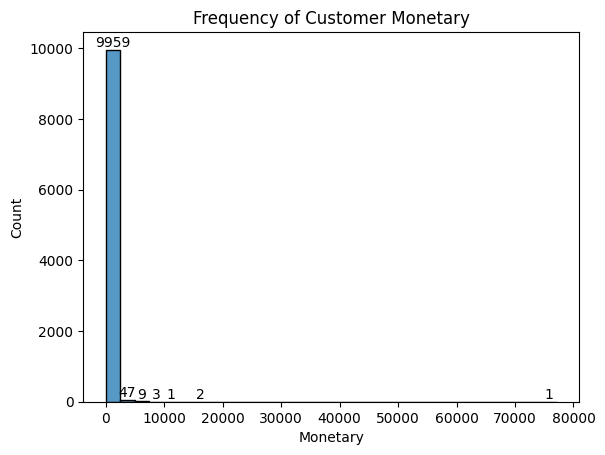

In [6]:
query = f"""
    WITH CustomerMonetary AS (
        SELECT
            fullVisitorId AS visitorId,
            COALESCE(totals.transactionRevenue, 0) AS transactionRevenue
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE totals.transactions >= 1
    )

    SELECT
        visitorId,
        SUM(transactionRevenue)/1e6 AS monetary
    FROM
        CustomerMonetary
    GROUP BY
        visitorId
    """
rows = client.query(query)

result_df = rows.to_dataframe()

ax = sns.histplot(result_df.monetary, binwidth=2500)

plt.title('Frequency of Customer Monetary')
plt.xlabel('Monetary')
plt.ylabel('Count')

for p in ax.patches:
    if int(p.get_height()) > 0:
        ax.annotate(
            f'{int(p.get_height())}',
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center',
            va='bottom'
        )

plt.show()

### Exit rate by Page Title


In [7]:
# Exit rate by pages
query = f"""
        SELECT hits.page.pageTitle as PageTitle, COUNT(*) AS Views, SUM(totals.bounces)/COUNT(*) AS ExitRate
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits
        WHERE hits.type='PAGE'
        GROUP BY PageTitle
        ORDER BY Views DESC
        LIMIT 10
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

                                           PageTitle   Views  ExitRate
0                                               Home  630465  0.164693
1                                Google Online Store  393684  0.510486
2                                      Shopping Cart  209266  0.020534
3  YouTube | Shop by Brand | Google Merchandise S...  157715  0.283683
4              The Google Merchandise Store - Log In  117629  0.050243
5  Men's T-Shirts | Apparel | Google Merchandise ...  101866  0.120570
6                               Store search results   78035  0.025322
7  Men's Outerwear | Apparel | Google Merchandise...   56217  0.057829
8        Backpacks | Bags | Google Merchandise Store   53449  0.017493
9                 Apparel | Google Merchandise Store   51610  0.048983 



Exit rates are the lowest when items from a specific category are being displayed


### Bounce rates by Page Title


In [8]:
# Bounce rate by pages
query = f"""
        SELECT hits.page.pageTitle AS PageTitle, COUNT(*) AS Views, SUM(totals.bounces)/COUNT(*) AS BounceRate
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) as hits
        WHERE hits.type = 'PAGE' AND hits.hitNumber = 1
        GROUP BY PageTitle
        ORDER BY Views DESC
        LIMIT 10
        """
rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

                                           PageTitle   Views  BounceRate
0                                Google Online Store  339352    0.592002
1                                               Home  275170    0.374627
2  YouTube | Shop by Brand | Google Merchandise S...   79314    0.563873
3  Men's T-Shirts | Apparel | Google Merchandise ...   26342    0.465758
4              The Google Merchandise Store - Log In   16321    0.361191
5                                   Page Unavailable   15965    0.404447
6                                      Shopping Cart    9428    0.454709
7  Men's Outerwear | Apparel | Google Merchandise...    7439    0.436618
8                    Bags | Google Merchandise Store    6928    0.460450
9               Drinkware | Google Merchandise Store    6834    0.557799 



### Patterns in customer behaviour


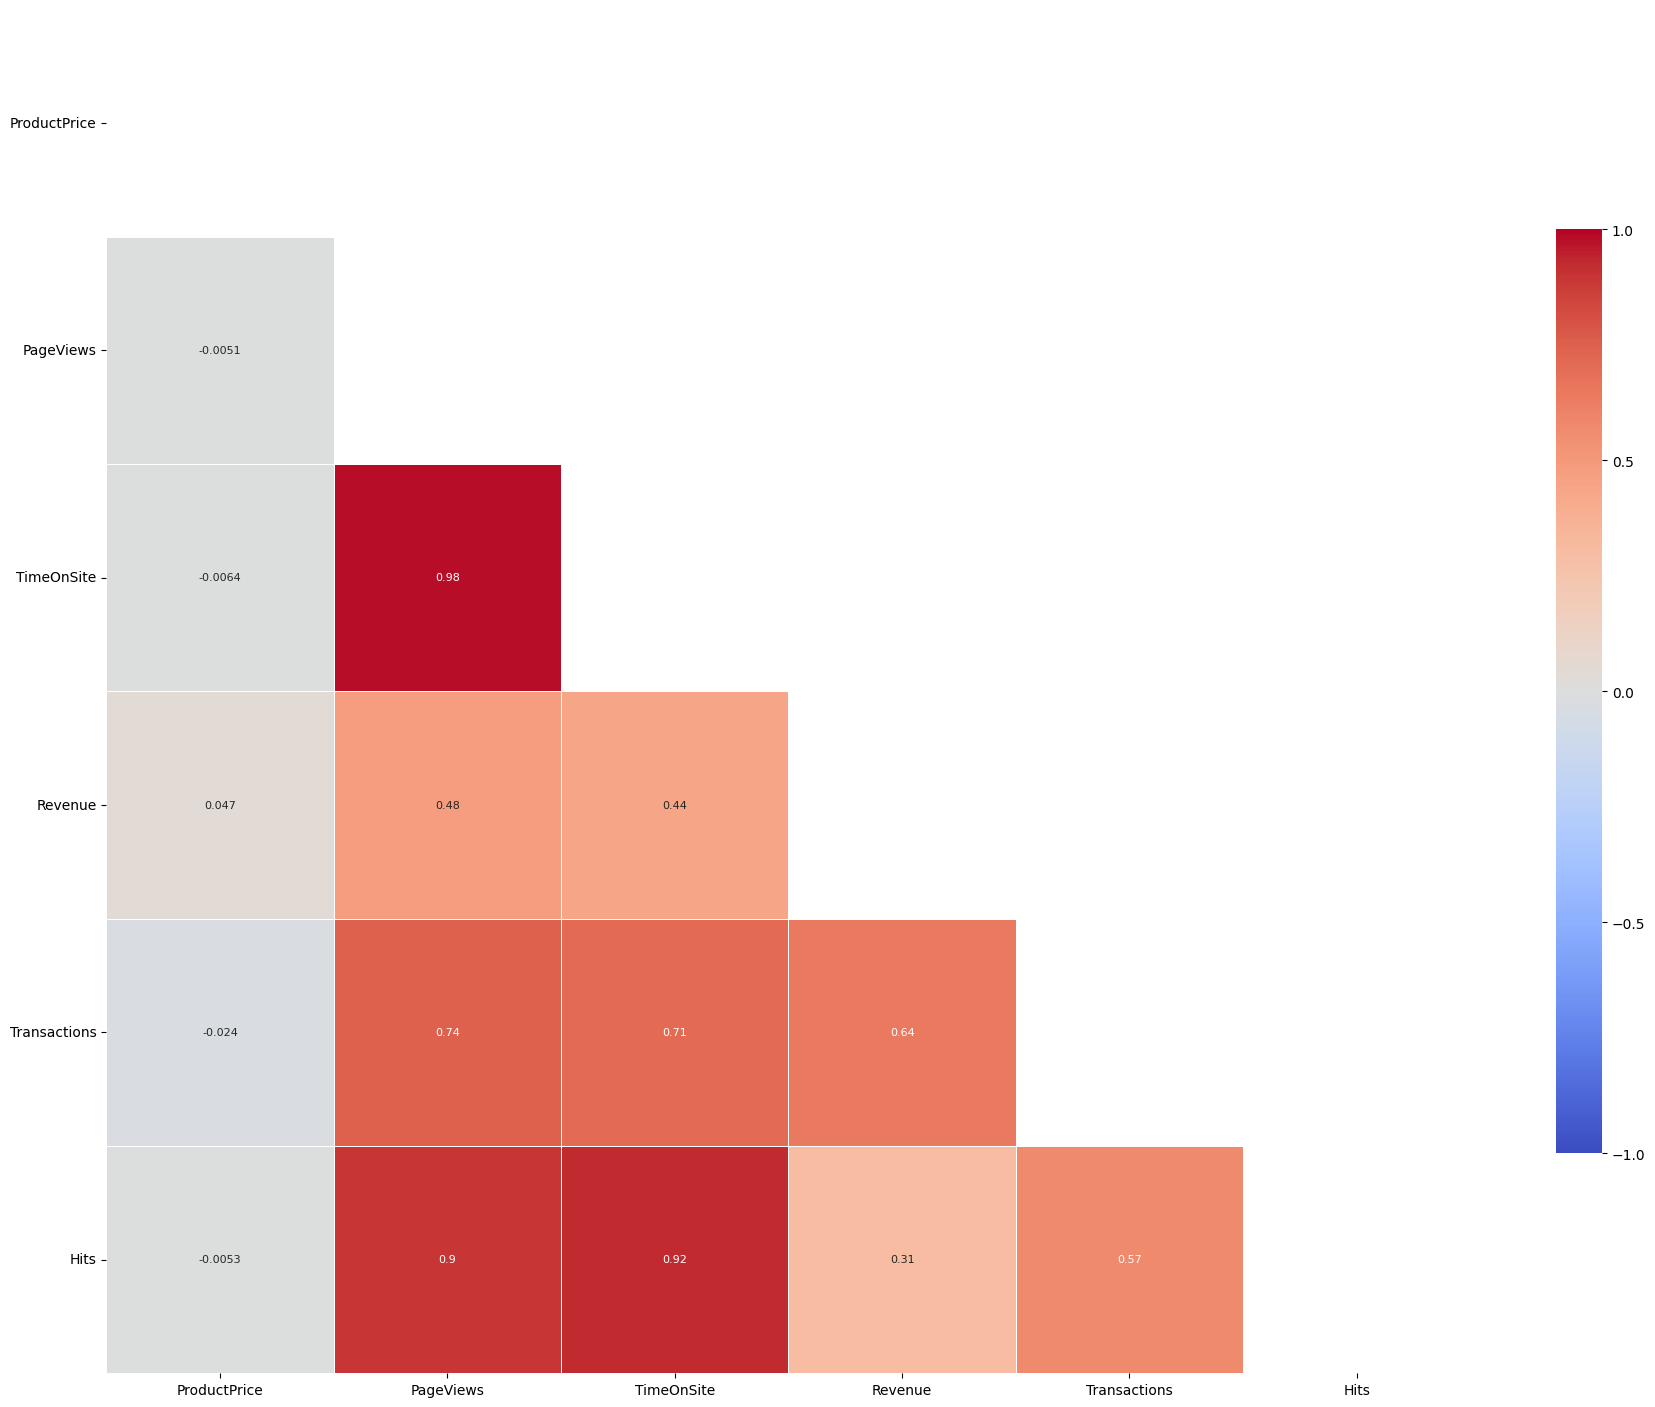

In [9]:
query = f"""
        SELECT channelGrouping AS ChannelGrouping, device.browser AS Browser, geoNetwork.country AS Country, prod.productListPosition AS ProductListPosition, hits.page.pagePath AS PagePath, prod.v2ProductCategory AS ProductCategory,  trafficSource.source AS TrafficSource, prod.productPrice AS ProductPrice, prod.productListName AS ProductListName, hits.promotionActionInfo.promoIsView AS PromoIsView, hits.promotionActionInfo.promoIsClick AS PromoIsClick,
        SUM(totals.pageviews) AS PageViews,  SUM(totals.timeOnSite) AS TimeOnSite, SUM(totals.totalTransactionRevenue)/1000000 AS Revenue, SUM(totals.transactions) AS Transactions, COUNT(totals.hits) AS Hits
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) as hits, UNNEST(hits.product) as prod
        GROUP BY 1,2,3,4,5,6,7,8,9,10,11
        """

rows = client.query(query)

result_df = rows.to_dataframe()

corr_matrix = result_df[['ProductPrice', 'PageViews',
                         'TimeOnSite', 'Revenue', 'Transactions', 'Hits']].corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(22, 30))
heatmap = sns.heatmap(corr_matrix,
                      square=True,
                      mask=mask,
                      linewidths=.5,
                      cmap='coolwarm',
                      cbar_kws={'shrink': .4, 'ticks': [-1, -.5, 0, 0.5, 1]},
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      annot_kws={'size': 8})
ax.set_yticklabels(corr_matrix.columns, rotation=0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

We can observe that as customers spend more time on the website, and views more pages from the website, it is more likely that the website handles more transactions and results in a higher revenue.


# Q2


How can we improve customer retention and lifetime value?

- Calculate customer churn rates and identify at-risk customers.
- Analyze the effectiveness of current retention strategies.


### Calculating yearly churn rates


In [10]:
query = f"""
        SELECT
            fullVisitorID,
            channelGrouping AS Channel,
            SUM(totals.totalTransactionRevenue) AS TotalRevenue,
            COUNT(fullVisitorID) AS CustomerPurchaseCount,
            trafficSource.source AS TrafficSource,
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits,
            UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160901' AND '20160930' AND
            hits.eCommerceAction.action_type = '6'
        GROUP BY fullVisitorID, Channel, TrafficSource
        ORDER BY CustomerPurchaseCount DESC
        LIMIT 10
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

         fullVisitorID         Channel  TotalRevenue  CustomerPurchaseCount TrafficSource
0  8851822767477687842        Referral   30878760000                     96      (direct)
1   666582393118140484        Referral   20600080000                     68      (direct)
2  3033366073043100694        Referral   11512000000                     60      (direct)
3  5689475961693395998        Referral   15128780000                     54      (direct)
4  9377429831454005466  Organic Search   20728520000                     52        google
5  8436426603099391262        Referral   37197920000                     52      (direct)
6  5632276788326171571          Direct  673375500000                     42      (direct)
7  5912152563864160997        Referral    9040400000                     40      (direct)
8  4923243433046835289          Direct   14585600000                     40      (direct)
9  6374969976921419865          Direct    7172800000                     40      (direct) 



The most popular channel that is used by customers with a high purchase count


In [11]:
# https://medium.com/octave-john-keells-group/a-simple-six-step-approach-to-define-customer-churn-in-retail-f401e31e57c0#:~:text=Identifying%20the%20point%20in%20which,time%20to%20proactively%20implement%20interventions.&text=Step%206%3A,is%20identified%20as%20a%20churner.
query = f"""
        -- Compute the Number of purchases made by each visitor in a day
        -- NULL transaction means that there are no transactions made
        WITH DailyPurchases AS (
            SELECT
                PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                fullVisitorID,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
            GROUP BY
                Date,
                fullVisitorID
        ),
        -- Compute the 30 Day Moving Average and the 90 Day Moving Average STD
        MovingAverages AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                COALESCE(
                    SUM(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    )/30, 0
                ) AS OneMonthMA,
                COALESCE(
                    STDDEV(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) * (COUNT(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) - 1) / 89, 0
                ) AS ThreeMonthSTDMA
            FROM
                DailyPurchases
        ),
        -- Find the threshold at which the customer is considered at risk of retention
        Threshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                (OneMonthMA - ThreeMonthSTDMA) AS LowerBound
            FROM
                MovingAverages
        ),
        -- Lag the threshold by 30 Days and the visitor should not be considered at risk immediately
        LaggingThreshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                COALESCE(
                    LAG(LowerBound, 29) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                ) AS LowerBoundOneMonthLag
            FROM
                Threshold
            ORDER BY
                Date
        ),
        -- Select only the latest date for each visitor and check for their churn status
        RankedDates AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                LowerBoundOneMonthLag,
                ROW_NUMBER() OVER (
                    PARTITION BY fullVisitorID
                    ORDER BY Date DESC
                ) AS rn
            FROM LaggingThreshold
        )

        SELECT Date, fullVisitorID, DailyPurchaseCount, OneMonthMA, LowerBound, LowerBoundOneMonthLag
        FROM RankedDates
        ORDER BY Date
        """

rows = client.query(query)

result_df = rows.to_dataframe()

# Sum of purchases by each visitor
grouped_sum = result_df.groupby('fullVisitorID')[
    'DailyPurchaseCount'].sum().reset_index()

grouped_sum = grouped_sum.rename(
    columns={'DailyPurchaseCount': 'HistoricPurchases'})

df = result_df.merge(grouped_sum, on='fullVisitorID',
                     how='left').query("HistoricPurchases > 0")

df['Date'] = pd.to_datetime(df['Date'])

# Only keep the entry of the last purchase
latest_idx = df.groupby('fullVisitorID')['Date'].idxmax()

result_df = df.loc[latest_idx].sort_values(by="Date")

print(result_df, "\n")

             Date        fullVisitorID  DailyPurchaseCount  OneMonthMA  LowerBound  LowerBoundOneMonthLag  HistoricPurchases
1314   2016-08-01  5760753352577829144                  79    2.633333    2.633333                    0.0                 79
449    2016-08-01  6569605994631186947                  36    1.200000    1.200000                    0.0                 36
1348   2016-08-01  2125540555068339394                  25    0.833333    0.833333                    0.0                 25
63     2016-08-01  7589137567725941774                  51    1.700000    1.700000                    0.0                 51
860    2016-08-01  5563168194966233133                  21    0.700000    0.700000                    0.0                 21
...           ...                  ...                 ...         ...         ...                    ...                ...
834749 2017-08-01   024507252193437459                  16    0.533333    0.406213                    0.0                 16


In [12]:
# Those that have not made a purchase within the last 3 months or have a monthly moving average less than the lower bound have a retention risk
max_date = result_df['Date'].max()
three_months_ago = max_date - pd.DateOffset(months=3)
RetentionRiskCount = len(set(result_df.query(
    "Date <= @three_months_ago | LowerBoundOneMonthLag >= OneMonthMA").fullVisitorID))

# Those that have made a purchase within the last 3 months or have a monthly moving average more than the lower bound do not have a retention risk
RetentionCount = len(set(result_df.query(
    "@three_months_ago <= Date <= @max_date & LowerBoundOneMonthLag < OneMonthMA").fullVisitorID))


result_df.query(
    "@three_months_ago <= Date <= @max_date & LowerBoundOneMonthLag < OneMonthMA")

,Date,fullVisitorID,DailyPurchaseCount,OneMonthMA,LowerBound,LowerBoundOneMonthLag,HistoricPurchases
651404,2017-05-01,536428604379922267,22,0.733333,0.733333,0.0,22
651177,2017-05-01,1749853719127085935,13,0.433333,0.433333,0.0,13
651874,2017-05-01,9740050408987139130,19,0.633333,0.633333,0.0,19
651781,2017-05-01,9565722193439879038,11,0.366667,0.279271,0.0,11
650321,2017-05-01,4501448098783068461,22,2.466667,1.636650,0.0,74
...,...,...,...,...,...,...,...
834749,2017-08-01,024507252193437459,16,0.533333,0.406213,0.0,16
833881,2017-08-01,5199370466032130686,0,0.866667,0.428464,0.0,26
834438,2017-08-01,3614707430894059857,28,0.933333,0.933333,0.0,28
835016,2017-08-01,9591202457292182670,20,0.666667,0.157052,0.0,20


These are the at risk customers as the lagged lower bound is greater or equal to their one month moving average on purchase count


In [13]:
query = f"""
        -- Compute the Number of purchases made by each visitor in a day
        -- NULL transaction means that there are no transactions made
        WITH DailyPurchases AS (
            SELECT
                PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                fullVisitorID,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
            GROUP BY
                Date,
                fullVisitorID
        ),
        -- Compute the 30 Day Moving Average and the 90 Day Moving Average STD
        MovingAverages AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                COALESCE(
                    SUM(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    )/30, 0
                ) AS OneMonthMA,
                COALESCE(
                    STDDEV(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) * (COUNT(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) - 1) / 89, 0
                ) AS ThreeMonthSTDMA
            FROM
                DailyPurchases
        ),
        -- Find the threshold at which the customer is considered at risk of retention
        Threshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                (OneMonthMA - ThreeMonthSTDMA) AS LowerBound
            FROM
                MovingAverages
        ),
        -- Lag the threshold by 30 Days and the visitor should not be considered at risk immediately
        LaggingThreshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                COALESCE(
                    LAG(LowerBound, 29) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                ) AS LowerBoundOneMonthLag
            FROM
                Threshold
            ORDER BY
                Date
        ),
        -- Find the channels used by those with a retention risk: Less than threshold or have not purchased within the last 3 months
        RetentionRisk AS (
            SELECT
                channelGrouping AS Channel,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS Transactions
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*` df
            RIGHT JOIN
                LaggingThreshold lt
            ON
                df.fullVisitorID = lt.fullVisitorID
            WHERE
                lt.LowerBoundOneMonthLag >= lt.OneMonthMA AND lt.Date < (SELECT MAX(Date) FROM LaggingThreshold) - INTERVAL 3 MONTH
            GROUP BY
                Channel
        ),
        TotalTransactions AS (
            SELECT
                SUM(Transactions) AS Total
            FROM
                RetentionRisk
        )

        SELECT
            Channel,
            Transactions,
            (Transactions / TotalTransactions.Total) * 100 AS Transactions_Pct
        FROM
            RetentionRisk,
            TotalTransactions
        ORDER BY
            Transactions_Pct DESC
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

          Channel  Transactions  Transactions_Pct
0        Referral          4419         43.154297
1  Organic Search          2360         23.046875
2         Display          1668         16.289062
3          Direct          1455         14.208984
4     Paid Search           239          2.333984
5          Social            96          0.937500
6      Affiliates             3          0.029297
7         (Other)             0          0.000000 



Overview of channels used by those who do not have a retention risk


In [14]:
query = f"""
        -- Compute the Number of purchases made by each visitor in a day
        -- NULL transaction means that there are no transactions made
        WITH DailyPurchases AS (
            SELECT
                PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                fullVisitorID,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
            GROUP BY
                Date,
                fullVisitorID
        ),
        -- Compute the 30 Day Moving Average and the 90 Day Moving Average STD
        MovingAverages AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                COALESCE(
                    SUM(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    )/30, 0
                ) AS OneMonthMA,
                COALESCE(
                    STDDEV(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) * (COUNT(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) - 1) / 89, 0
                ) AS ThreeMonthSTDMA
            FROM
                DailyPurchases
        ),
        -- Find the threshold at which the customer is considered at risk of retention
        Threshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                (OneMonthMA - ThreeMonthSTDMA) AS LowerBound
            FROM
                MovingAverages
        ),
        -- Lag the threshold by 30 Days and the visitor should not be considered at risk immediately
        LaggingThreshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                COALESCE(
                    LAG(LowerBound, 29) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                ) AS LowerBoundOneMonthLag
            FROM
                Threshold
            ORDER BY
                Date
        ),
        -- Find the channels used by those without a retention risk: More than threshold or have purchased within the last 3 months
        Retention AS (
            SELECT
                channelGrouping AS Channel,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS Transactions
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*` df
            RIGHT JOIN
                LaggingThreshold lt
            ON
                df.fullVisitorID = lt.fullVisitorID
            WHERE
                lt.LowerBoundOneMonthLag < lt.OneMonthMA AND lt.Date >= (SELECT MAX(Date) FROM LaggingThreshold) - INTERVAL 3 MONTH
            GROUP BY
                Channel
        ),
        TotalTransactions AS (
            SELECT
                SUM(Transactions) AS Total
            FROM
                Retention
        )

        SELECT
            Channel,
            Transactions,
            (Transactions / TotalTransactions.Total) * 100 AS Transactions_Pct
        FROM
            Retention,
            TotalTransactions
        ORDER BY
            Transactions_Pct DESC
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

          Channel  Transactions  Transactions_Pct
0        Referral          3695         39.812520
1          Direct          2193         23.628919
2  Organic Search          2133         22.982437
3         Display           884          9.524836
4     Paid Search           307          3.307833
5          Social            63          0.678806
6      Affiliates             6          0.064648
7         (Other)             0          0.000000 



Overview of channels used by those who do not have a retention risk


In [15]:
ChurnRate = (RetentionRiskCount /
             (RetentionRiskCount + RetentionCount)) * 100

print("The churn rate for google online store is :", round(ChurnRate, 4), "% \n")

The churn rate for google online store is : 69.2704 % 



### Evaluating current retention strategies


In [16]:

# https://medium.com/@busegungor2303/calculation-of-cltv-and-prediction-of-cltv-71c4f754dd90
query = f"""
        SELECT COALESCE(totals.totalTransactionRevenue, 0)/1e6 AS TotalRevenue, COALESCE(totals.transactions) AS Transactions, fullVisitorId
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        """

rows = client.query(query)

result_df = rows.to_dataframe()

# Only for those where transactions > 0 since we are looking at customers and not visitors
sub_df = result_df.query("Transactions > 0")
sub_df = sub_df.groupby("fullVisitorId").sum()
sub_df['AvgOrderValue'] = sub_df.TotalRevenue / sub_df.Transactions

print(sub_df.sort_values("AvgOrderValue").query("AvgOrderValue > 0"), '\n')

AvgCustomerValue = sub_df.TotalRevenue.sum() / len(sub_df)
# The average value of a customer that purchases
print("Customer value is: ", round(AvgCustomerValue, 5), '\n')

# The likelihood of a customer making a second purchase
AvgRepeatRate = len(sub_df.query("Transactions > 1")) / len(sub_df)
print("Repeat rate is: ", round(AvgRepeatRate*100, 4), '% \n')

                     TotalRevenue  Transactions  AvgOrderValue
fullVisitorId                                                 
9367883304718826385          1.20             1            1.2
3568593840277988902          3.01             2          1.505
0136876972401975041          2.04             1           2.04
3073830805992104825          2.49             1           2.49
7161524936078300347          2.50             1            2.5
...                           ...           ...            ...
7965265156545901045       4849.60             1         4849.6
5469079519715865124       5608.40             1         5608.4
1957458976293878100     128412.52            22    5836.932727
7496147812697146114       7003.50             1         7003.5
5632276788326171571      16032.75             1       16032.75

[9996 rows x 3 columns] 

Customer value is:  177.62415 

Repeat rate is:  11.6344 % 



In [18]:
# Repeat rate for valuable customers
val_sub_df = sub_df.query(f"AvgOrderValue > {AvgCustomerValue}")
val_RepeatRate = len(val_sub_df.query("Transactions > 1")) / len(val_sub_df)

print(f"The repeat rate for valuable customers is: {
      round(val_RepeatRate*100, 4)}", '% \n')

The repeat rate for valuable customers is: 24.4152 % 



Since the repeat rate for valuable customers is greater then the average (24% > 11.6%), current retention strategies are effective in retaining valuable customers.


# Q3


What are the most effective marketing channels and campaigns?

- Evaluate the ROI of different marketing channels.

- Analyze the impact of various promotional campaigns on sales - Ads & Promotion position


### Evalutaing revenue of different marketing channels


In [19]:
query = f"""
        SELECT
            channelGrouping AS Channel,
            trafficSource.source AS TrafficSource,
            COUNT(fullVisitorID) AS UserCount
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits,
            UNNEST(hits.product) AS product
        WHERE
            hits.eCommerceAction.action_type != '0'
        GROUP BY TrafficSource, Channel
        ORDER BY UserCount DESC
        LIMIT 10
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

          Channel         TrafficSource  UserCount
0  Organic Search                google     339732
1        Referral              (direct)     338334
2          Direct              (direct)     234482
3  Organic Search              (direct)     197849
4     Paid Search                google      29673
5          Social           youtube.com      26201
6     Paid Search              (direct)      21580
7         Display                   dfa      14255
8      Affiliates              Partners      10965
9        Referral  analytics.google.com       6205 



Using the dataframe above, we can find which platform and channel is the most popular.


In [20]:
query = f"""
        SELECT
            channelGrouping AS Channel,
            SUM(totals.totalTransactionRevenue) AS TotalRevenue,
            COUNT(fullVisitorID) AS UserCount,
            SUM(totals.totalTransactionRevenue/1e6) / COUNT(fullVisitorID) AS AVGRevenuePerUserInMilllions,
            trafficSource.source AS TrafficSource,
            CASE
                WHEN hits.eCommerceAction.action_type = '1' THEN 'Click product lists'
                WHEN hits.eCommerceAction.action_type = '2' THEN 'View product details'
                WHEN hits.eCommerceAction.action_type = '3' THEN 'Add to cart'
                WHEN hits.eCommerceAction.action_type = '4' THEN 'Remove from cart'
                WHEN hits.eCommerceAction.action_type = '5' THEN 'Check out'
                WHEN hits.eCommerceAction.action_type = '6' THEN 'Purchase'
                WHEN hits.eCommerceAction.action_type = '7' THEN 'Refund'
                WHEN hits.eCommerceAction.action_type = '0' THEN 'Unknown'
            END AS Action
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits,
            UNNEST(hits.product) AS product
        WHERE
            hits.eCommerceAction.action_type = '6'
        GROUP BY Action, TrafficSource, Channel
        ORDER BY UserCount DESC
        LIMIT 20
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

           Channel   TotalRevenue  UserCount  AVGRevenuePerUserInMilllions            TrafficSource    Action
0         Referral  6861093620000      32354                    212.063226                 (direct)  Purchase
1           Direct  9231074220000      14684                    628.648476                 (direct)  Purchase
2   Organic Search  3403071550000      13419                    253.600980                   google  Purchase
3   Organic Search  1709765760000       7592                    225.206238                 (direct)  Purchase
4      Paid Search   361601340000       1628                    222.113845                   google  Purchase
5      Paid Search   207373340000       1296                    160.010293                 (direct)  Purchase
6          Display  4605551900000       1010                   4559.952376                      dfa  Purchase
7         Referral   374165040000        578                    647.344360          mail.google.com  Purchase
8         

Referral searches via a direct traffic source attracts the greatest number of users.

However, the display channel via the dfa traffic source generates the greatest revenue per user.


In [21]:
# For each page title, find the number of customers and the way people are able to search for their products -> Which is the most effective
query = f"""
        SELECT
            IF(LENGTH(hits.page.pageTitle) <= 20, hits.page.pageTitle, CONCAT(SUBSTR(hits.page.pageTitle, 1, 20), '...')) AS PageTitle,
            channelGrouping AS Channel,
            COUNT(fullVisitorID) AS VisitorCount,
            SUM(IF(totals.transactions IS NULL, 0, totals.transactions)) AS TransactionCount,
            SUM(totals.totalTransactionRevenue/1e6) AS TotalRevenue
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits
        WHERE hits.page.pageTitle NOT LIKE '%Checkout%'
            AND hits.page.pageTitle NOT LIKE '%Home%'
            AND hits.page.pageTitle NOT LIKE '%Cart%'
            AND hits.page.pageTitle NOT LIKE '%Google%'
            AND hits.page.pageTitle NOT LIKE '%Payment%'
            AND hits.page.pageTitle NOT LIKE '%results%'
        GROUP BY PageTitle, Channel
        ORDER BY VisitorCount DESC
        LIMIT 20
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

           PageTitle         Channel  VisitorCount  TransactionCount  TotalRevenue
0     Men's-T-Shirts  Organic Search         31922              2698     410113.98
1             Office  Organic Search         22441              2107     339173.57
2   Page Unavailable        Referral         21349               499      66833.21
3               Bags  Organic Search         19002              1288     415953.97
4        Electronics  Organic Search         18657              2486     873982.35
5          Drinkware  Organic Search         17328              1861     519384.35
6     Men's-T-Shirts        Referral         14478              3573     493624.68
7            Apparel  Organic Search         12960               899     263526.79
8          Lifestyle  Organic Search         12844              1428     221770.16
9               Bags        Referral         11839              1474     304820.03
10            Office        Referral         11747              2691     737288.10
11  

Referral and organic searches are clearly the most popular traffic channels and a higher traffic generally equates to a higher transaction count


### Impact of promotional campaign through Promotion Position


In [22]:
query = """
        SELECT  
                promotion.promoName AS PromotionName, promotion.promoCreative AS PromoCreative, promotion.promoPosition AS PromoPosition,
                hits.promotionActionInfo.promoIsView AS PromoViewed, hits.promotionActionInfo.promoIsClick AS PromoClick, 
                totals.transactions AS Transactions, totals.hits AS Hits
        FROM 
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits, UNNEST(hits.promotion) AS promotion
        """

rows = client.query(query)

result_df = rows.to_dataframe()

result_df["Transactions"] = result_df.Transactions.fillna(0)
result_df["PromoClick"] = result_df.PromoClick.fillna(False)
result_df["PromoViewed"] = result_df.PromoViewed.fillna(False)

sub_df = result_df[["PromoViewed", "PromoClick", "Transactions",
                    "PromoPosition", "Hits"]].groupby("PromoPosition").sum()
sub_df["PromoClickThroughRate"] = (
    sub_df.PromoClick + sub_df.PromoViewed) / sub_df.Hits
sub_df = pd.merge(sub_df, result_df.PromoPosition.value_counts(
).reset_index(), on="PromoPosition", how="inner")
sub_df["TransactionRate"] = sub_df.Transactions / sub_df['count']
sub_df.sort_values("PromoClickThroughRate", ascending=False)[
    ["PromoPosition", "TransactionRate", "PromoClickThroughRate", "PromoClick", "PromoViewed", "Hits"]]

,PromoPosition,TransactionRate,PromoClickThroughRate,PromoClick,PromoViewed,Hits
3,HomeBanner_BottomSlot_Central,0.0,1.0,0,1,1
4,HomeBanner_BottomSlot_Left,0.0,1.0,0,1,1
5,HomeBanner_BottomSlot_Right,0.0,1.0,0,1,1
6,HomeBanner_TopSlot_1,0.0,1.0,0,1,1
13,Row 3-1,0.036581,0.088487,0,622859,7038994
2,Brand Row 7-3,0.036424,0.088279,4330,622859,7104652
1,Brand Row 7-2,0.036339,0.088218,8614,622859,7158134
14,Row 3-2,0.036503,0.088076,3882,622859,7115892
0,Brand Row 7-1,0.036405,0.088016,8430,622859,7172434
15,Row 4 Color Combo,0.036496,0.087929,5679,622859,7148271


Position of promotion does not have a strong relationship to transaction rates and its click through rate.


### Impact of promotional campaign through Ads


In [23]:
query = """
        SELECT  
                trafficSource.adContent AS AdContent,
                trafficSource.adwordsClickInfo.page AS AdPage, 
                trafficSource.adwordsClickInfo.slot AS AdPosition, 
                SUM(COALESCE(totals.transactions, 0)) AS TotalTransactions, 
                SUM(totals.hits) AS Hits
        FROM 
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        GROUP BY AdContent, AdPage, AdPosition
        ORDER BY TotalTransactions DESC
        LIMIT 20
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

                          AdContent  AdPage AdPosition  TotalTransactions     Hits
0                              None    <NA>       None              11638  3989702
1                              None       1        Top                326   108559
2     Google Merchandise Collection       1        Top                119    33812
3                              None       1        RHS                  6     1233
4           Full auto ad IMAGE ONLY    <NA>       None                  5     2723
5               Google Online Store       1        Top                  4     3459
6        Display Ad created 3/11/14    <NA>       None                  3     4581
7            Swag with Google Logos       1        Top                  3      553
8     {KeyWord:Google Branded Gear}       1        Top                  3      460
9                      20% discount    <NA>       None                  2      554
10  {KeyWord:Want Google Stickers?}       1        Top                  2      323
11  

Ads on the first page and at the top are more likely to recieve a greater number of transactions and hits.


In [24]:
query = """
        SELECT  
                trafficSource.adContent AS AdContent,
                trafficSource.adwordsClickInfo.page AS AdPage, 
                trafficSource.adwordsClickInfo.slot AS AdPosition, 
                SUM(COALESCE(totals.transactions, 0)) AS TotalTransactions, 
                SUM(totals.hits) AS Hits
        FROM 
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        GROUP BY AdContent, AdPage, AdPosition
        ORDER BY TotalTransactions DESC
        LIMIT 20
        """

rows = client.query(query)

result_df = rows.to_dataframe()

sub_df = result_df.query(
    "AdPosition.isna() | ~AdPosition.isna()")
sub_df["AdPage"] = sub_df["AdPage"].notna()
sub_df["AdPosition"] = sub_df["AdPosition"].notna()

sub_df = sub_df.groupby(["AdPage", "AdPosition"])[
    ["TotalTransactions", "Hits"]].sum().reset_index()
sub_df['TransactionRate'] = sub_df.TotalTransactions / sub_df.Hits

print(sub_df, '\n')
print("Likelihood of purchase after viewing an Ad is: ",
      round((sub_df.at[1, "TransactionRate"] - sub_df.at[0, "TransactionRate"]) / sub_df.at[0, "TransactionRate"]*100, 4),  "%", " greater than when no Ad is viewed.")

   AdPage  AdPosition  TotalTransactions     Hits  TransactionRate
0   False       False              11650  3999228         0.002913
1    True        True                465   150753         0.003085 

Likelihood of purchase after viewing an Ad is:  5.8857 %  greater than when no Ad is viewed.
